In [1]:
# Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2023 over the Pacific Basin (65°N to 65°S, 120°E to 60°W)
 #masked out over land - save this to your computer.
 #Plot maps of the mean SST and mean total column water vapor for the entire period of record.

In [2]:
from dask.distributed import Client, progress
client = Client(dashboard_address=':5555')  
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:5555/status,
Dashboard: http://127.0.0.1:5555/status,Workers: 4
Total threads: 12,Total memory: 15.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54828,Workers: 4
Dashboard: http://127.0.0.1:5555/status,Total threads: 12
Started: Just now,Total memory: 15.79 GiB
Comm: tcp://127.0.0.1:54848,Total threads: 3
Dashboard: http://127.0.0.1:54853/status,Memory: 3.95 GiB
Nanny: tcp://127.0.0.1:54831,


In [27]:
# Import libraries

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings

from eofs.xarray import Eof
warnings.filterwarnings("ignore")

In [4]:
degree_step_size= 4

In [5]:
filename = 'era5data_pacificbasin_sst_vapor.nc'

if os.path.exists(filename):
    # Read saved data
    ds= xr.open_dataset(filename)

else:
    # Pull the data only if not available locally
    ds = xr.open_dataset('https://thredds.rda.ucar.edu/thredds/dodsC/aggregations/g/ds633.1/2/TP',
                     chunks={'time':'500MB'})

    variables = ['Total_column_water_vapour_surface_Mixed_intervals_Average','Sea_surface_temperature_surface_Mixed_intervals_Average']
    
    #select the two needed variables every 4th point to get 1 degree resolution
    ds = ds[variables].sel(lat=slice(65, -65, degree_step_size), lon=slice(120, 300, degree_step_size))
    ds.to_netcdf(filename)

In [6]:
ds

<xarray.Dataset> Size: 97MB
Dimensions:                                                    (time: 516,
                                                                lat: 130,
                                                                lon: 181)
Coordinates:
  * lat                                                        (lat) float32 520B ...
  * lon                                                        (lon) float32 724B ...
  * time                                                       (time) datetime64[ns] 4kB ...
    reftime                                                    (time) datetime64[ns] 4kB ...
Data variables:
    Total_column_water_vapour_surface_Mixed_intervals_Average  (time, lat, lon) float32 49MB ...
    Sea_surface_temperature_surface_Mixed_intervals_Average    (time, lat, lon) float32 49MB ...
Attributes:
    Originating_or_generating_Center:     European Centre for Medium Range We...
    Originating_or_generating_Subcenter:  0
    GRIB_table_version:                   0,128
    file_format:                          GRIB-1
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    _CoordSysBuilder:                     ucar.nc2.dataset.conv.CF1Convention

In [7]:
sst_avg= ds["Sea_surface_temperature_surface_Mixed_intervals_Average"]
sst_avg= sst_avg/10


In [8]:
#Finding Sea Surface Temp anomalies
#import pandas as pd

sst_avg_mean_along_lat_lon = sst_avg.mean(dim= ['lon','lat'])

sst_avg_mean_along_lat_lon.to_pandas()
ninety_five_percentile_sst = np.percentile(sst_avg_mean_along_lat_lon.to_pandas().to_numpy(), 95, method="inverted_cdf")
print("The 95%-value is --", ninety_five_percentile_sst)

The 95%-value is -- 29.196896


In [9]:
#Sea Surface Temp Along time
sst_avg_mean_along_time = sst_avg.mean(dim= ['time'])
sst_anomalies = sst_avg_mean_along_time.where(sst_avg_mean_along_time>= ninety_five_percentile_sst, drop =True)


In [10]:
sst_anomalies

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             lat: 79,
                                                                             lon: 181)> Size: 57kB
array([[      nan,       nan,       nan, ..., 29.200706, 29.226988,
        29.24074 ],
       [      nan,       nan,       nan, ..., 29.436005, 29.44704 ,
        29.431862],
       [      nan,       nan,       nan, ..., 29.569479, 29.56108 ,
        29.549383],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 316B 40.75 39.75 38.75 37.75 ... -35.25 -36.25 -37.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0

In [11]:
#Land Sea Mask

url = "https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc"

ds_lsm = xr.open_dataset(url)[["LSM"]]
ds_lsm = ds_lsm.rename({"latitude": "lat", "longitude": "lon"})

ds_lsm = ds_lsm.sel(lat=slice(64.9, -65, degree_step_size), lon=slice(120, 300, degree_step_size))
ds_lsm = ds_lsm.mean(dim=['time'])
ds_lsm

<xarray.Dataset> Size: 97kB
Dimensions:  (lat: 130, lon: 181)
Coordinates:
  * lat      (lat) float64 1kB 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float64 1kB 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
Data variables:
    LSM      (lat, lon) float32 94kB 0.982 0.9716 0.9474 ... 0.1706 0.533 1.0

In [12]:
#Plotting the Anamalies

import warnings

import matplotlib.pyplot as plt
import numpy as np
import cartopy
from cartopy import crs as ccrs, feature as cfeature

Jan 1979-Dec 2023

In [13]:
#Land Sea Mask

url = "https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc"

ds_lsm = xr.open_dataset(url)[["LSM"]]
ds_lsm = ds_lsm.rename({"latitude": "lat", "longitude": "lon"})

ds_lsm = ds_lsm.sel(lat=slice(64.9, -65, degree_step_size), lon=slice(120, 300, degree_step_size))
ds_lsm = ds_lsm.mean(dim=['time'])
ds_lsm["lat"] = sst_avg_mean_along_time["lat"]
ds_lsm["lon"] = sst_avg_mean_along_time["lon"]



In [14]:
ds_lsm

<xarray.Dataset> Size: 95kB
Dimensions:  (lat: 130, lon: 181)
Coordinates:
  * lat      (lat) float32 520B 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
Data variables:
    LSM      (lat, lon) float32 94kB 0.982 0.9716 0.9474 ... 0.1706 0.533 1.0

In [15]:
sst_avg_mean_along_time

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             lat: 130,
                                                                             lon: 181)> Size: 94kB
array([[      nan,       nan,       nan, ..., 27.262539, 27.27167 ,
        27.282272],
       [      nan,       nan,       nan, ..., 27.286   , 27.30408 ,
        27.356598],
       [      nan,       nan,       nan, ..., 27.317636, 27.384333,
        27.468073],
       ...,
       [27.272854, 27.272774, 27.275507, ..., 27.29894 , 27.299335,
        27.28363 ],
       [27.247711, 27.252256, 27.25421 , ..., 27.265795, 27.27594 ,
        27.222977],
       [27.21154 , 27.215193, 27.216587, ..., 27.21389 , 27.173502,
              nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 520B 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0

In [16]:
sst_avg_lsm = sst_avg_mean_along_time.where(ds_lsm <1, drop=True)

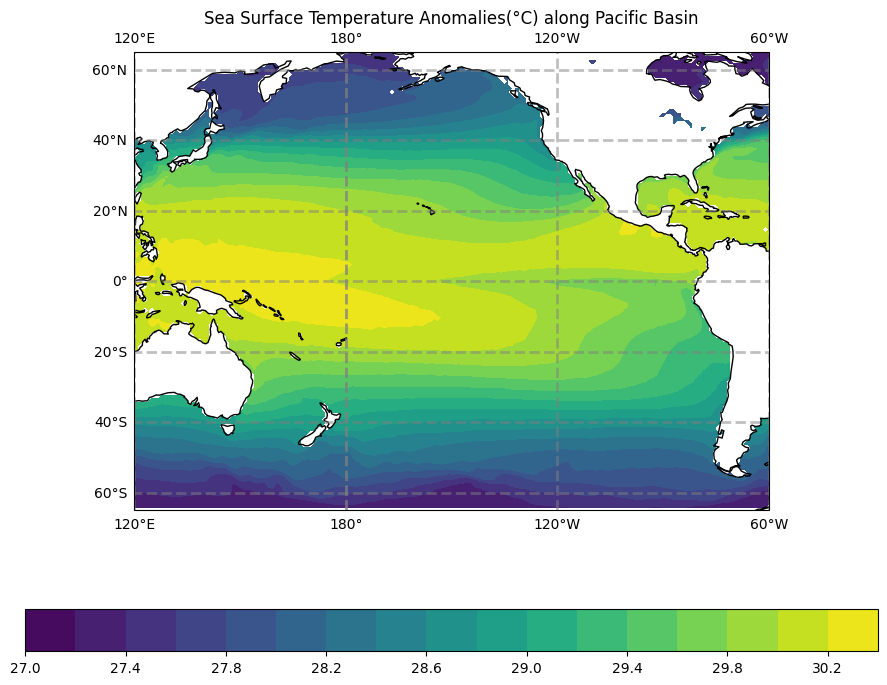

In [17]:

lonW = 120
lonE = 300
latS = -65
latN = 65


crs0 = ccrs.PlateCarree(central_longitude=0)
crs_pacific = ccrs.PlateCarree(central_longitude=-150)

res = '110m'
fig = plt.figure(figsize=(11, 8.5))
ax = plt.subplot(1, 1, 1, projection=crs_pacific)
ax.set_title('Sea Surface Temperature Anomalies(°C) along Pacific Basin')
gl = ax.gridlines(
    draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--'
)
ax.set_extent([lonW, lonE, latS, latN], crs=crs0)
ax.coastlines(resolution=res, color='black')
lon, lat = np.meshgrid(sst_avg_lsm["lon"].to_numpy(),
                       sst_avg_lsm["lat"].to_numpy())
data = sst_avg_lsm.to_dataframe().to_numpy().reshape(lat.shape)
# print(lat.shape)
# print(lon.shape)

dataplot = ax.contourf(lon, lat, data, transform=crs0, levels=20)
plt.colorbar(dataplot, orientation="horizontal")

In [18]:

total_column_water_vapor = ds['Total_column_water_vapour_surface_Mixed_intervals_Average']
total_column_water_vapor= total_column_water_vapor.mean(dim=['time'])
total_column_water_vapor_lsm = total_column_water_vapor.where(ds_lsm<0.05, drop=True)

In [19]:
total_column_water_vapor_lsm

<xarray.Dataset> Size: 95kB
Dimensions:  (lat: 130, lon: 181)
Coordinates:
  * lat      (lat) float32 520B 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
Data variables:
    LSM      (lat, lon) float32 94kB nan nan nan nan nan ... nan nan nan nan nan

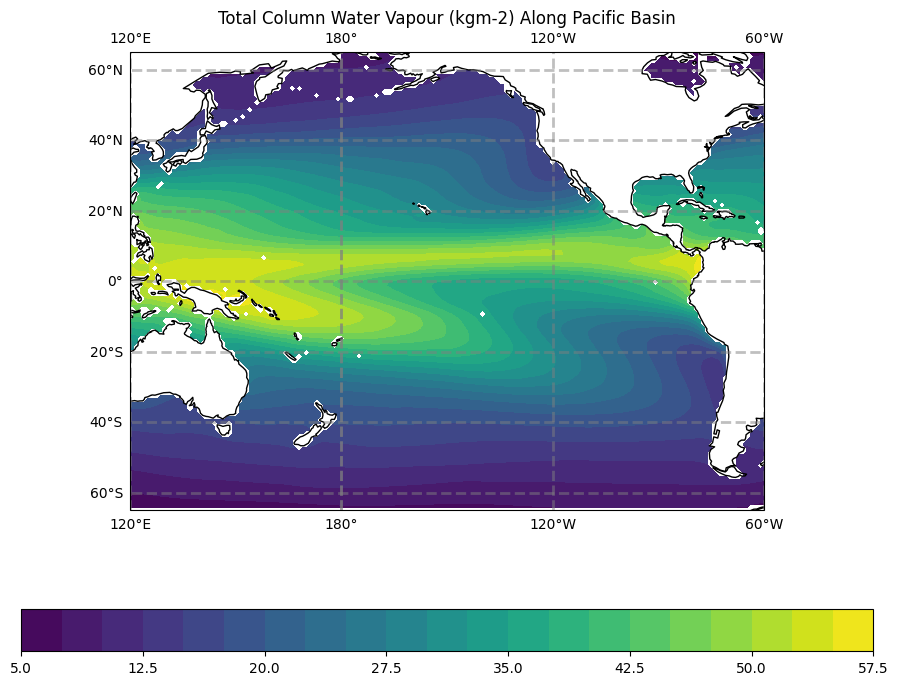

In [20]:
lonW = 120
lonE = 300
latS = -65
latN = 65


crs0 = ccrs.PlateCarree(central_longitude=0)
crs_pacific = ccrs.PlateCarree(central_longitude=-150)

res = '110m'
fig = plt.figure(figsize=(11, 8.5))
ax = plt.subplot(1, 1, 1, projection=crs_pacific)
ax.set_title('Total Column Water Vapour (kgm-2) Along Pacific Basin')
gl = ax.gridlines(
    draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--'
)
ax.set_extent([lonW, lonE, latS, latN], crs=crs0)
ax.coastlines(resolution=res, color='black')
lon, lat = np.meshgrid(total_column_water_vapor_lsm["lon"].to_numpy(),
                       total_column_water_vapor_lsm["lat"].to_numpy())
data = total_column_water_vapor_lsm.to_dataframe().to_numpy().reshape(lat.shape)
# print(lat.shape)
# print(lon.shape)

dataplot = ax.contourf(lon, lat, data, transform=crs0, levels=20)
plt.colorbar(dataplot, orientation="horizontal")

In [35]:
#Finding Anomalies and Climatology date range: Jan 1979-Dec 2023 
clm = (sst_avg.sel(time=slice('1979-01-01','2021-12-31')).groupby('time.month').mean(dim='time'))
anm = (sst_avg.groupby('time.month')-clm)
anm


<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 516,
                                                                             lat: 130,
                                                                             lon: 181)> Size: 49MB
array([[[           nan,            nan,            nan, ...,
         -9.5367432e-06, -5.4931641e-04, -2.7484894e-03],
        [           nan,            nan,            nan, ...,
         -4.8255920e-04, -8.5639954e-04,  4.2764664e-02],
        [           nan,            nan,            nan, ...,
          5.5179596e-03,  5.3953171e-02,  9.4495773e-02],
        ...,
        [ 1.3528824e-02, -3.2768250e-03, -4.5528412e-03, ...,
         -4.9242020e-02, -3.8127899e-02, -1.8400192e-02],
        [-3.1097412e-02, -3.5919189e-02, -4.4542313e-02, ...,
         -3.1637192e-02, -1.6923904e-02,  3.0473709e-02],
        [-4.1875839e-02, -4.4424057e-02, -5.3415298e-02, ...,
         -9.4627380e-02, -9.2742920e-02,            nan]],

       [[           nan,            nan,            nan, ...,
          1.3351440e-05,  5.7220459e-06, -3.4904480e-04],
        [           nan,            nan,            nan, ...,
         -4.0054321e-05, -3.8528442e-04,  3.0088425e-02],
        [           nan,            nan,            nan, ...,
          3.2062531e-03,  6.0598373e-02,  9.8449707e-02],
...
        [ 2.8404236e-02,  2.8858185e-02,  2.4229050e-02, ...,
          4.8408508e-02,  7.6374054e-02,  8.1768036e-02],
        [-2.3803711e-03,  9.5481873e-03,  2.4099350e-02, ...,
          7.5151443e-02,  6.5292358e-02,  5.2072525e-02],
        [-3.3740997e-03, -4.7931671e-03, -5.9490204e-03, ...,
          9.5819473e-02,  3.3905029e-02,            nan]],

       [[           nan,            nan,            nan, ...,
          9.0389252e-03,  9.1114044e-03,  3.1108856e-03],
        [           nan,            nan,            nan, ...,
          8.3141327e-03,  6.2503815e-03,  3.4868240e-02],
        [           nan,            nan,            nan, ...,
          3.4503937e-03,  4.7893524e-02,  9.0370178e-02],
        ...,
        [-1.0271072e-02, -9.1457367e-03, -1.1625290e-02, ...,
          2.7236938e-03,  1.7974854e-02,  3.2064438e-02],
        [ 9.9735260e-03,  5.6018829e-03,  9.7293854e-03, ...,
          3.2773972e-02,  1.6138077e-02,  1.5359879e-02],
        [-6.3705444e-04,  3.3264160e-03,  1.2996674e-02, ...,
          9.7223282e-02,  6.0630798e-02,            nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 520B 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time     (time) datetime64[ns] 4kB 1979-01-16T12:00:00 ... 2021-12-16T12:...
    reftime  (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2021-12-01
    month    (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

In [36]:
# Detrending SST Anomalies (anm)

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit


# Perform detrending
detrended_anm = detrend_dim(anm, dim='time', deg=1)
detrended_anm_SD = detrended_anm/detrended_anm.std(dim='time').compute()


In [26]:
#Save the detrended , standarized SST anomalies file
detrended_anm_SD.to_netcdf("detrended_standarized_SST_anm.nc")

In [42]:
#Read the SST Anomalies data
sst_anm_preproc= xr.open_dataarray("detrended_standarized_SST_anm.nc")
sst_anm_preproc


<xarray.DataArray (time: 516, lat: 130, lon: 181)> Size: 97MB
[12141480 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 520B 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time     (time) datetime64[ns] 4kB 1979-01-16T12:00:00 ... 2021-12-16T12:...
    reftime  (time) datetime64[ns] 4kB ...
    month    (time) int64 4kB ...

# Part 3 : EOF Analysis


In [43]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst_anm_preproc.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst_anm_preproc, weights=wgts)

# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eofs5 = solver.eofsAsCorrelation(neofs=5)


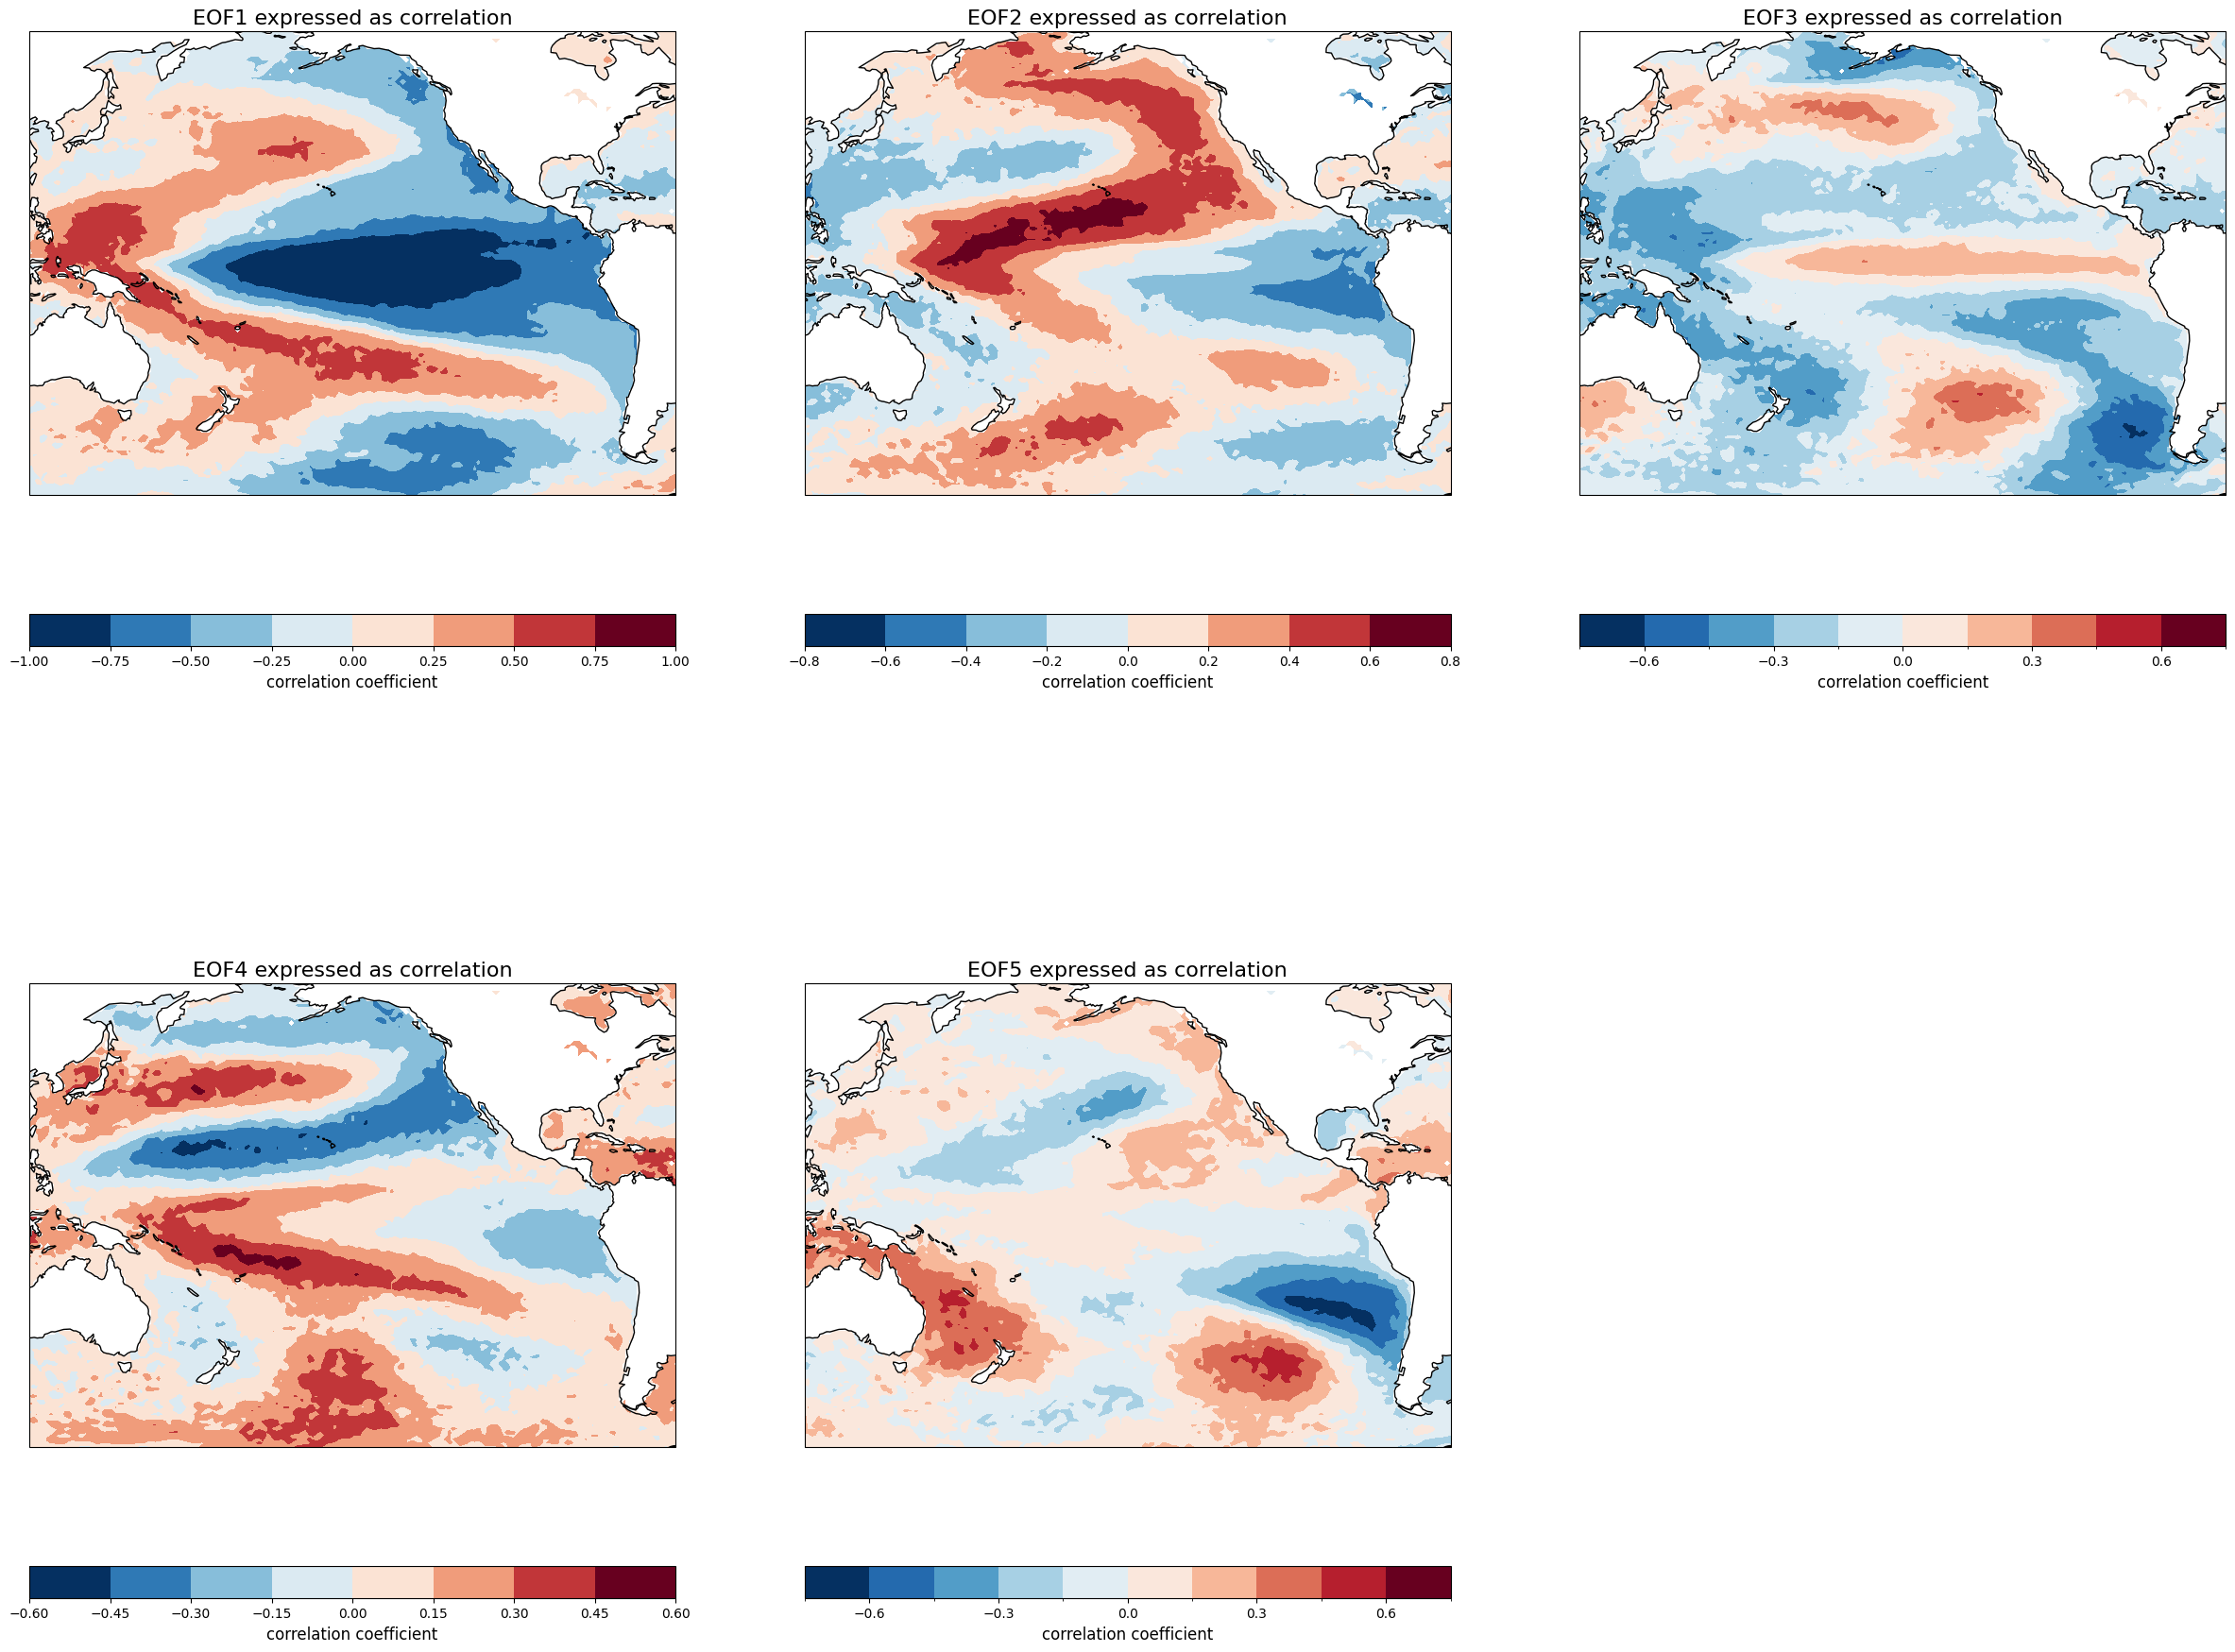

In [44]:
fig = plt.figure(figsize=(30, 24))

for ieof in range(5):
    ax = plt.subplot(2, 3, ieof+1, projection=ccrs.PlateCarree(central_longitude=-150))
    fill = eofs5[ieof].plot.contourf(ax=ax, levels=10, cmap=plt.cm.RdBu_r,
                                     add_colorbar=False, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    cb = plt.colorbar(fill, orientation='horizontal')
    cb.set_label('correlation coefficient', fontsize=12)
    ax.set_title(f'EOF{ieof+1} expressed as correlation', fontsize=16)

# Part 4: Plotting the percent of variance explained by the first 10 EOFs.

In [45]:
varfrac = solver.varianceFraction()
varperc =100*varfrac

(1.9135734486819958e-31, 18.29202755470871)

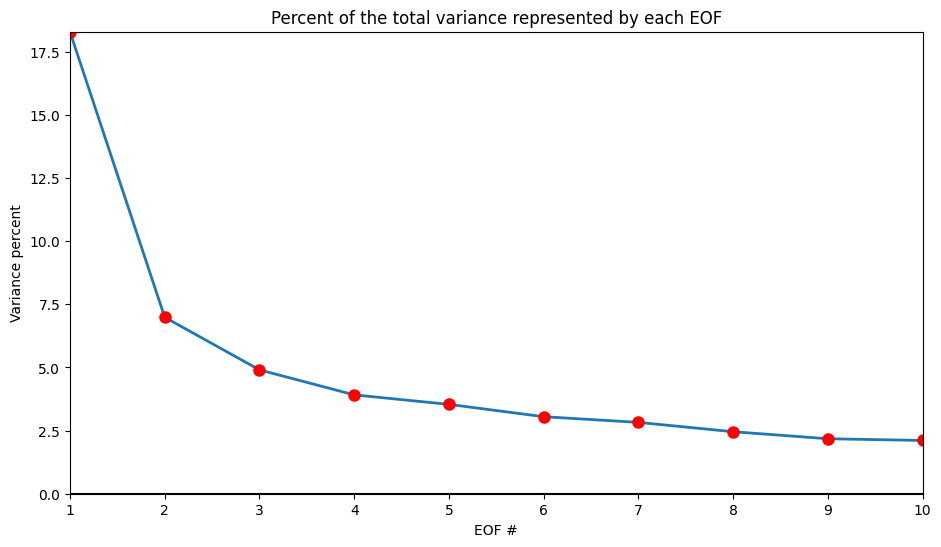

In [46]:
# Plot the fraction of variance explained by each EOF
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varperc[0:10], linewidth=2)
plt.plot(eof_num, varperc[0:10], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Percent of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance percent')
plt.xlim(1, 10)
plt.ylim(np.min(varperc), np.max(varperc)+0.01)

### Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient 

In [52]:
sst_observed = sst_avg

In [48]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.

coslat = np.cos(np.deg2rad(sst_observed.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst_observed, weights=wgts)

# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eofs5 = solver.eofsAsCorrelation(neofs=5)


In [51]:
reconstructed_sst = solver.reconstructedField(5)
reconstructed_sst

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 516,
                                                                             lat: 130,
                                                                             lon: 181)> Size: 49MB
array([[[        nan,         nan,         nan, ..., -0.09068224,
         -0.10087339, -0.11487187],
        [        nan,         nan,         nan, ..., -0.11625043,
         -0.14163439, -0.18867703],
        [        nan,         nan,         nan, ..., -0.15437521,
         -0.20674725, -0.25114238],
        ...,
        [ 0.16161048,  0.167361  ,  0.1658317 , ...,  0.15639858,
          0.1542428 ,  0.14014205],
        [ 0.1512748 ,  0.15169172,  0.15075645, ...,  0.11523686,
          0.12548049,  0.09397514],
        [ 0.11951568,  0.12127689,  0.12072147, ...,  0.04766271,
          0.04243768,         nan]],

       [[        nan,         nan,         nan, ..., -0.10126364,
         -0.10956991, -0.12170956],
        [        nan,         nan,         nan, ..., -0.12230431,
         -0.14702304, -0.20423228],
        [        nan,         nan,         nan, ..., -0.15918203,
         -0.22351593, -0.2810314 ],
...
        [-0.06368165, -0.06889395, -0.06795529, ..., -0.02418233,
         -0.02104509, -0.00719749],
        [-0.05787777, -0.05722079, -0.05479576, ...,  0.00602739,
          0.01544668,  0.0353695 ],
        [-0.04466783, -0.04248886, -0.03907751, ...,  0.0805605 ,
          0.03446279,         nan]],

       [[        nan,         nan,         nan, ..., -0.02736648,
         -0.04639189, -0.06119855],
        [        nan,         nan,         nan, ..., -0.06130467,
         -0.07817742, -0.07281475],
        [        nan,         nan,         nan, ..., -0.09474733,
         -0.09041134, -0.03881208],
        ...,
        [ 0.03805611,  0.03413324,  0.0345646 , ...,  0.07874626,
          0.0791669 ,  0.08376103],
        [ 0.03655944,  0.03791131,  0.04048203, ...,  0.08905116,
          0.09889851,  0.09732071],
        [ 0.02950617,  0.03345724,  0.0372605 , ...,  0.12864752,
          0.06576088,         nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-16T12:00:00 ... 2021-12-16T12:...
  * lat      (lat) float32 520B 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
    reftime  (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2021-12-01
Attributes:
    long_name:  Sea_surface_temperature_surface_Mixed_intervals_Average_recon...

In [53]:
cor_reconstructed_vs_observed= xr.corr(reconstructed_sst, sst_observed, dim="time")
cor_reconstructed_vs_observed

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             lat: 130,
                                                                             lon: 181)> Size: 94kB
array([[       nan,        nan,        nan, ..., 0.90709585, 0.91716695,
        0.922447  ],
       [       nan,        nan,        nan, ..., 0.9368523 , 0.942561  ,
        0.944735  ],
       [       nan,        nan,        nan, ..., 0.9502386 , 0.95333976,
        0.9373607 ],
       ...,
       [0.95773405, 0.9588145 , 0.9589188 , ..., 0.9648231 , 0.9647632 ,
        0.9601965 ],
       [0.9451852 , 0.95014435, 0.95156   , ..., 0.96549547, 0.961142  ,
        0.8946407 ],
       [0.91722476, 0.9222259 , 0.9226237 , ..., 0.80645025, 0.6516649 ,
               nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 520B 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0

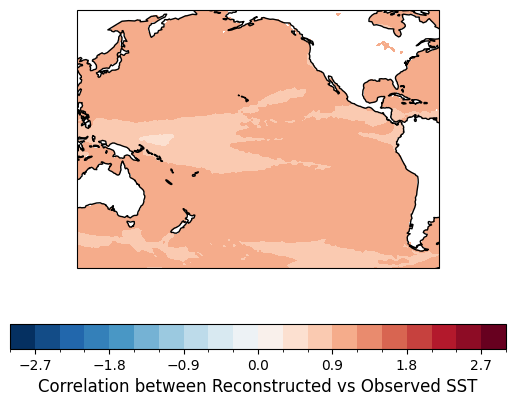

In [54]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-3, 3, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-150))
fill = cor_reconstructed_vs_observed.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('Correlation between Reconstructed vs Observed SST', fontsize=12)

In [ ]:
 Compute a map of the Pearson's correlation coefficient 
between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies 
(don't mask these over land for the plot).  See anything interesting?

<xarray.DataArray 'Total_column_water_vapour_surface_Mixed_intervals_Average' (
                                                                               lat: 130,
                                                                               lon: 181)> Size: 94kB
array([[8.045034 , 8.003855 , 7.933188 , ..., 7.2652626, 7.301556 ,
        7.3453784],
       [8.37536  , 8.399798 , 8.395335 , ..., 7.540066 , 7.58028  ,
        7.6451983],
       [8.327965 , 8.27446  , 8.178176 , ..., 7.831519 , 7.8995957,
        7.982397 ],
       ...,
       [6.6010046, 6.642698 , 6.687775 , ..., 7.800156 , 7.7307844,
        7.6080174],
       [6.1961045, 6.2419133, 6.2850037, ..., 7.343944 , 7.350072 ,
        7.1706514],
       [5.7423973, 5.7851033, 5.8230634, ..., 6.843616 , 5.137864 ,
        3.6780043]], dtype=float32)
Coordinates:
  * lat      (lat) float32 520B 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0

In [59]:
# Total column water vapor observed

tcwv_observed = ds['Total_column_water_vapour_surface_Mixed_intervals_Average']
tcwv_observed

<xarray.DataArray 'Total_column_water_vapour_surface_Mixed_intervals_Average' (
                                                                               time: 516,
                                                                               lat: 130,
                                                                               lon: 181)> Size: 49MB
array([[[1.096357, 1.139325, ..., 4.121747, 4.288739],
        [1.078779, 1.120771, ..., 4.278974, 4.494794],
        ...,
        [7.361005, 7.406903, ..., 9.878583, 9.584638],
        [7.055341, 7.09538 , ..., 7.107099, 5.30827 ]],

       [[1.3328  , 1.334754, ..., 3.388464, 3.610144],
        [1.461707, 1.464636, ..., 3.751746, 4.126746],
        ...,
        [8.338659, 8.410925, ..., 9.965612, 9.813269],
        [7.674597, 7.802527, ..., 7.098425, 5.289832]],

       ...,

       [[3.254613, 3.229222, ..., 5.946019, 6.201879],
        [3.507543, 3.505589, ..., 6.458714, 6.65598 ],
        ...,
        [4.987035, 5.027074, ..., 8.069066, 7.864964],
        [4.597386, 4.632543, ..., 5.576879, 3.890355]],

       [[1.728397, 1.691287, ..., 4.685428, 4.936405],
        [1.786991, 1.747928, ..., 4.804569, 5.066288],
        ...,
        [8.394412, 8.287967, ..., 8.747928, 8.56824 ],
        [7.458866, 7.316288, ..., 6.328006, 4.570194]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 520B 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time     (time) datetime64[ns] 4kB 1979-01-16T12:00:00 ... 2021-12-16T12:...
    reftime  (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2021-12-01
Attributes: (12/14)
    long_name:                       Total column water vapour (Mixed_interva...
    units:                           kg m**-2
    grid_mapping:                    LatLon_Projection
    Grib_Statistical_Interval_Type:  Average
    Grib_Variable_Id:                VAR_98-0-128-137_L1_Imixed_S123
    Grib1_Center:                    98
    ...                              ...
    Grib1_Parameter:                 137
    Grib1_Parameter_Name:            tcwv
    Grib1_Level_Type:                1
    Grib1_Level_Desc:                Ground or water surface
    Grib1_Interval_Type:             123
    Grib1_Interval_Name:             Average of N uninitialized analyses, int...

In [ ]:
#Finding Anomalies and Climatology date range: Jan 1979-Dec 2023 
clm_tcwv = (tcwv_observed.sel(time=slice('1979-01-01','2021-12-31')).groupby('time.month').mean(dim='time'))
anm_tcwv = (tcwv_observed.groupby('time.month')-clm)
anm_tcwv

In [61]:
# Detrending TCWV Anomalies (anm_tcwv)

# Perform detrending
detrended_anm_tcwv = detrend_dim(anm_tcwv, dim='time', deg=1)
detrended_anm_SD_tcwv = detrended_anm_tcwv/detrended_anm_tcwv.std(dim='time').compute()


In [62]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.

coslat = np.cos(np.deg2rad(sst_observed.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst_observed, weights=wgts)


# Calculating EOF1 for SST_observed
eofs1 = solver.eofsAsCorrelation(neofs=2)


In [65]:
cor_SST_EOF1_vs_tcwv= xr.corr(eofs1[0], detrended_anm_SD_tcwv, dim="time")
cor_SST_EOF1_vs_tcwv

<xarray.DataArray (lat: 130, lon: 181)> Size: 188kB
array([[            nan,             nan,             nan, ...,
        -1.28205385e-17, -3.78005711e-18,  2.47863745e-17],
       [            nan,             nan,             nan, ...,
         3.53862323e-17,  1.85897809e-17,  2.99595067e-17],
       [            nan,             nan,             nan, ...,
         1.70630839e-17,  2.65568298e-17, -2.09546644e-18],
       ...,
       [ 2.30440216e-17, -1.74859785e-17,  1.83602774e-18, ...,
         1.72542366e-17, -1.72127601e-18, -1.94928919e-17],
       [ 3.21304855e-17, -1.81186948e-18,  3.20237397e-18, ...,
        -3.59222819e-18, -1.17193260e-18, -8.72113177e-18],
       [-1.59218031e-17,  3.04613693e-17, -3.72605630e-17, ...,
         2.85731817e-17, -2.93463450e-18,             nan]])
Coordinates:
    mode     int32 4B 0
  * lat      (lat) float32 520B 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0

In [67]:
eofs1[0]

<xarray.DataArray 'eofs' (lat: 130, lon: 181)> Size: 94kB
array([[        nan,         nan,         nan, ...,  0.82032126,
         0.840678  ,  0.857201  ],
       [        nan,         nan,         nan, ...,  0.859579  ,
         0.88159084,  0.90882194],
       [        nan,         nan,         nan, ...,  0.89198446,
         0.9174823 ,  0.9108506 ],
       ...,
       [-0.89170253, -0.88968956, -0.89072406, ..., -0.9174933 ,
        -0.91711766, -0.9046392 ],
       [-0.85183924, -0.8655408 , -0.8689838 , ..., -0.9050461 ,
        -0.8945052 , -0.7537363 ],
       [-0.77204156, -0.78558975, -0.78977793, ..., -0.60924095,
        -0.50547004,         nan]], dtype=float32)
Coordinates:
    mode     int32 4B 0
  * lat      (lat) float32 520B 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
Attributes:
    long_name:  correlation_between_pcs_and_Sea_surface_temperature_surface_M...

In [70]:
detrended_anm_SD_tcwv.mean()

<xarray.DataArray (time: 516, lat: 130, lon: 181)> Size: 97MB
array([[[        nan,         nan,         nan, ..., -0.60745106,
         -0.59028222, -0.56875251],
        [        nan,         nan,         nan, ..., -0.63026539,
         -0.6067055 , -0.57726648],
        [        nan,         nan,         nan, ..., -0.6366569 ,
         -0.60801414, -0.58082948],
        ...,
        [ 0.61746933,  0.60334048,  0.55836208, ...,  1.81087107,
          1.73612097,  1.6580969 ],
        [ 0.59203331,  0.59414529,  0.61045279, ...,  1.62087106,
          1.54583822,  1.47640358],
        [ 0.67629788,  0.67199776,  0.67915121, ...,  1.6354637 ,
          1.60755086,         nan]],

       [[        nan,         nan,         nan, ..., -0.79229079,
         -0.7579143 , -0.72624756],
        [        nan,         nan,         nan, ..., -0.77802146,
         -0.72568153, -0.65967062],
        [        nan,         nan,         nan, ..., -0.73643955,
         -0.6570935 , -0.58644238],
...
        [-0.72892927, -0.72811394, -0.71842135, ...,  0.33233779,
          0.3414175 ,  0.35022632],
        [-0.679014  , -0.68495342, -0.68745613, ...,  0.4353251 ,
          0.44095318,  0.40200394],
        [-0.61492453, -0.61622711, -0.59165532, ...,  0.44353009,
          0.33204981,         nan]],

       [[        nan,         nan,         nan, ..., -0.69403278,
         -0.67642645, -0.64169494],
        [        nan,         nan,         nan, ..., -0.72467169,
         -0.70047074, -0.67039901],
        [        nan,         nan,         nan, ..., -0.7436717 ,
         -0.71909065, -0.70399961],
        ...,
        [ 1.50921452,  1.52692088,  1.50599753, ...,  0.78481441,
          0.78988879,  0.80085092],
        [ 1.57340395,  1.46330284,  1.32393292, ...,  0.8107242 ,
          0.80398265,  0.79620368],
        [ 1.20830393,  1.08304561,  0.94917445, ...,  0.89876469,
          0.90553583,         nan]]])
Coordinates:
  * lat      (lat) float32 520B 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time     (time) datetime64[ns] 4kB 1979-01-16T12:00:00 ... 2021-12-16T12:...
    reftime  (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2021-12-01
    month    (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

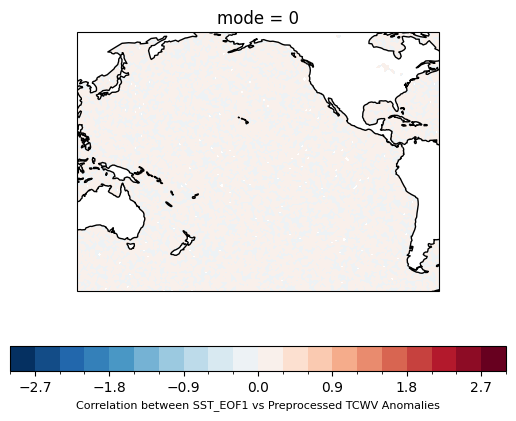

In [73]:
# Plot the leading EOF1 expressed as correlation in the Pacific domain.

clevs = np.linspace(-3, 3, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-150))
fill = cor_SST_EOF1_vs_tcwv.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('Correlation between SST_EOF1 vs Preprocessed TCWV Anomalies', fontsize=8)